In [ ]:
#Import all the necessary libraries

In [ ]:
pip install download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import download
from random import shuffle
from keras.applications import VGG16
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
import h5py

In [ ]:
keras.__version__

'2.9.0'

In [ ]:
#Helper Functions

In [ ]:
#print_progress to print the amount of videos processed

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [ ]:
#download_data to download the datasets

In [ ]:
def download_data(in_dir, url):
  if not os.path.exists(in_dir):
    os.makedirs(in_dir)
  download.maybe_download_and_extract(url,in_dir)

In [ ]:
#Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/HockeyFights.zip

Archive:  /content/drive/MyDrive/HockeyFights.zip
  inflating: no499_xvid.avi          
  inflating: no498_xvid.avi          
  inflating: no497_xvid.avi          
  inflating: no496_xvid.avi          
  inflating: no495_xvid.avi          
  inflating: no493_xvid.avi          
  inflating: no494_xvid.avi          
  inflating: no492_xvid.avi          
  inflating: no491_xvid.avi          
  inflating: no490_xvid.avi          
  inflating: no489_xvid.avi          
  inflating: no488_xvid.avi          
  inflating: no486_xvid.avi          
  inflating: no487_xvid.avi          
  inflating: no485_xvid.avi          
  inflating: no484_xvid.avi          
  inflating: no482_xvid.avi          
  inflating: no483_xvid.avi          
  inflating: no481_xvid.avi          
  inflating: no480_xvid.avi          
  inflating: no479_xvid.avi          
  inflating: no478_xvid.avi          
  inflating: no477_xvid.avi          
  inflating: no476_xvid.avi          
  inflating: no475_xvid.avi          


In [ ]:


#Copy some of the data-dimensions for convenience.

# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"



In [ ]:

#Helper-function for getting video frames

#Function used to get 20 frames from a video file and convert the frame to a suitable format for the neural net.

def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul



In [ ]:

#Helper function to get the names of the data downloaded and label it

def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels



In [ ]:

#Plot a video frame to see if data is correct

# First get the names and labels of the whole videos
names, labels = label_video_names('/content')



In [ ]:
names,labels

(('no276_xvid.avi',
  'no382_xvid.avi',
  'no429_xvid.avi',
  'fi377_xvid.avi',
  'no457_xvid.avi',
  'no247_xvid.avi',
  'no175_xvid.avi',
  'no215_xvid.avi',
  'fi142_xvid.avi',
  'fi284_xvid.avi',
  'no171_xvid.avi',
  'fi99_xvid.avi',
  'no358_xvid.avi',
  'no442_xvid.avi',
  'no139_xvid.avi',
  'no485_xvid.avi',
  'fi115_xvid.avi',
  'fi156_xvid.avi',
  'fi333_xvid.avi',
  'fi418_xvid.avi',
  'fi460_xvid.avi',
  'fi489_xvid.avi',
  'no116_xvid.avi',
  'fi282_xvid.avi',
  'fi168_xvid.avi',
  'fi150_xvid.avi',
  'fi67_xvid.avi',
  'no267_xvid.avi',
  'no330_xvid.avi',
  'fi296_xvid.avi',
  'fi194_xvid.avi',
  'fi75_xvid.avi',
  'no392_xvid.avi',
  'fi127_xvid.avi',
  'fi114_xvid.avi',
  'no249_xvid.avi',
  'no65___xvid.avi',
  'fi121_xvid.avi',
  'no342_xvid.avi',
  'fi234_xvid.avi',
  'no30_xvid.avi',
  'no333_xvid.avi',
  'fi449_xvid.avi',
  'no275_xvid.avi',
  'fi323_xvid.avi',
  'no230_xvid.avi',
  'fi263_xvid.avi',
  'fi386_xvid.avi',
  'no383_xvid.avi',
  'fi367_xvid.avi',
  '

In [ ]:


#Then we are going to load 20 frames of one video, for example

names[12]

'no358_xvid.avi'

In [ ]:


#The video has violence, look at the name of the video, starts with 'fi'

frames = get_frames('/content/', names[12])



In [ ]:
frames

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [ ]:
#Convert back the frames to uint8 pixel format to plot the frame

visible_frame = (frames*255).astype('uint8')



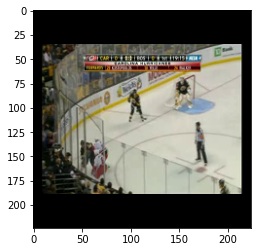

In [ ]:
plt.imshow(visible_frame[3])

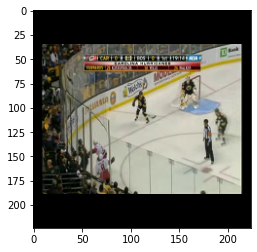

In [ ]:


plt.imshow(visible_frame[15])



In [ ]:
#Pre-Trained Model: VGG16

In [ ]:
image_model = VGG16(include_top=True, weights='imagenet')

553467096/553467096 [==============================] - 35s 0us/step


In [ ]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
input_shape = image_model.layers[0].output_shape[1:3]
input_shape

[]

In [ ]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [ ]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [ ]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [ ]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, '/content/', labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, '/content/', labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:

#Split the dataset into training set and test set

#We are going to split the dataset into training set and testing. The training set is used to train the model and the test set to check the model accuracy.

training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]



In [ ]:
training_set

800

In [ ]:
#Then we are going to process all video frames through VGG16 and save the transfer values.

make_files(training_set)



1/1 [==============================] - 0s 22ms/step
- Progress: 99.9%

In [ ]:
make_files_test(test_set)

1/1 [==============================] - 0s 22ms/step
- Progress: 99.5%

In [ ]:

#Load the cached transfer values into memory

#We have already saved all the videos transfer values into disk. But we have to load those transfer values into memory in order to train the LSTM net. One question would be: why not process transfer values and load them into RAM memory? Yes is a more eficient way to train the second net. But if you have to train the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing the videos through VGG16 net.

#In order to load the saved transfer values into RAM memory we are going to use this two functions:

def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target



In [ ]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:


data, target = process_alldata_training()



In [ ]:
data

[array([[0.        , 0.03603789, 1.6289221 , ..., 0.        , 0.        ,
         0.91793823],
        [0.        , 0.09165737, 1.5985252 , ..., 0.        , 0.        ,
         0.91456133],
        [0.        , 0.11717859, 1.5447686 , ..., 0.        , 0.        ,
         0.9231974 ],
        ...,
        [0.        , 0.08015636, 1.5264351 , ..., 0.        , 0.        ,
         0.92803276],
        [0.        , 0.06901127, 1.543824  , ..., 0.        , 0.        ,
         0.95191294],
        [0.        , 0.03597   , 1.5372674 , ..., 0.        , 0.        ,
         0.96887994]], dtype=float32),
 array([[0.        , 0.05609903, 1.5909945 , ..., 0.        , 0.        ,
         0.92583364],
        [0.        , 0.05980811, 1.6040362 , ..., 0.        , 0.        ,
         0.9117774 ],
        [0.        , 0.03894609, 1.5903678 , ..., 0.        , 0.        ,
         0.8950568 ],
        ...,
        [0.        , 0.        , 1.5079943 , ..., 0.        , 0.        ,
         0.89851195

In [ ]:
target

[array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0.

In [ ]:


data_test, target_test = process_alldata_test()



In [ ]:
target_test

[array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0.

In [ ]:
test_target=[0]*200
for i in range(len(target_test)):
  test_target[i]=int(target_test[i][0])

In [ ]:

#Define LSTM architecture

#When defining the LSTM architecture we have to take into account the dimensions of the transfer values. From each frame the VGG16 network obtains as output a vector of 4096 transfer values. From each video we are processing 20 frames so we will have 20 x 4096 values per video. The classification must be done taking into account the 20 frames of the video. If any of them detects violence, the video will be classified as violent.

#The first input dimension of LSTM neurons is the temporal dimension, in our case it is 20. The second is the size of the features vector (transfer values).
from tensorflow.keras.layers import Bidirectional
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(Bidirectional(LSTM(rnn_size, input_shape=(n_chunks, chunk_size))))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])



In [ ]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:750]), np.array(target[0:750]), epochs=epoch,
                    validation_data=(np.array(data[750:]), np.array(target[750:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/200
2/2 - 6s - loss: 0.3553 - accuracy: 0.4933 - val_loss: 0.3730 - val_accuracy: 0.5800 - 6s/epoch - 3s/step
Epoch 2/200
2/2 - 1s - loss: 0.4217 - accuracy: 0.4880 - val_loss: 0.2436 - val_accuracy: 0.5800 - 582ms/epoch - 291ms/step
Epoch 3/200
2/2 - 1s - loss: 0.2577 - accuracy: 0.5093 - val_loss: 0.3010 - val_accuracy: 0.4200 - 617ms/epoch - 308ms/step
Epoch 4/200
2/2 - 1s - loss: 0.2659 - accuracy: 0.5120 - val_loss: 0.2595 - val_accuracy: 0.4200 - 598ms/epoch - 299ms/step
Epoch 5/200
2/2 - 1s - loss: 0.2505 - accuracy: 0.5120 - val_loss: 0.2468 - val_accuracy: 0.5800 - 587ms/epoch - 293ms/step
Epoch 6/200
2/2 - 1s - loss: 0.2520 - accuracy: 0.4880 - val_loss: 0.2452 - val_accuracy: 0.5800 - 600ms/epoch - 300ms/step
Epoch 7/200
2/2 - 1s - loss: 0.2520 - accuracy: 0.4880 - val_loss: 0.2467 - val_accuracy: 0.5800 - 585ms/epoch - 293ms/step
Epoch 8/200
2/2 - 1s - loss: 0.2506 - accuracy: 0.4880 - val_loss: 0.2491 - val_accuracy: 0.5800 - 577ms/epoch - 289ms/step
Epoch 9/200
2/

In [ ]:

#Test the model

#We are going to test the model with 20 % of the total videos. This videos have not been used to train the network.

result = model.evaluate(np.array(data_test), np.array(target_test))



7/7 [==============================] - 0s 18ms/step - loss: 0.0246 - accuracy: 0.9700


In [ ]:
pred=model.predict(np.array(data_test))

7/7 [==============================] - 0s 18ms/step


In [ ]:
for i in range(len(pred)):
  if(pred[i][0]>pred[i][1]):
    pred[i][0]=1
    pred[i][1]=0
  else:
    pred[i][1]=1
    pred[i][0]=0

In [ ]:
pred

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.

In [ ]:
test_pred=[0]*200
for i in range(len(pred)):
  test_pred[i]=int(pred[i][0])

In [ ]:
test_pred

[1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0]

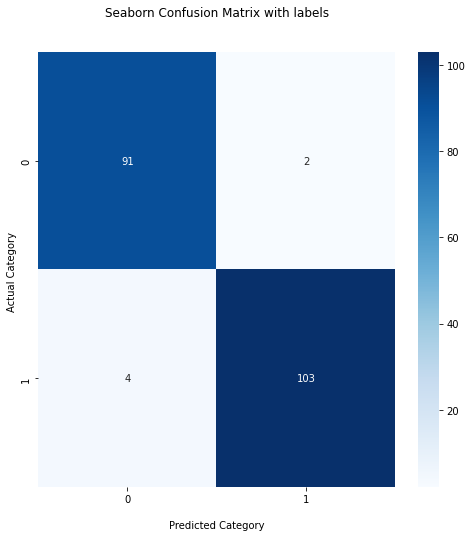

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        93
           1       0.98      0.96      0.97       107

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
cf_matrix = confusion_matrix(test_pred,test_target)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Display the visualization of the Confusion Matrix.
plt.show()
print(classification_report(test_pred, test_target))

In [ ]:
#Print the model accuracy

for name, value in zip(model.metrics_names, result):
    print(name, value)



loss 0.02458116225898266
accuracy 0.9700000286102295


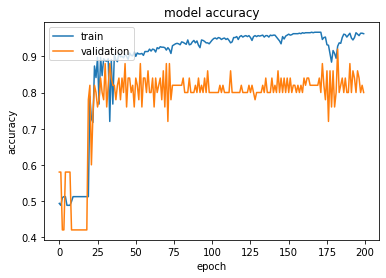

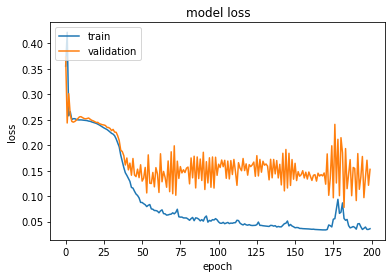

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()